In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from Preprocess import Preprocess
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
import ast

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
# 학습용 데이터 로드
df = pd.read_csv('../data/수정데이터/ner_train_data.csv')
df.head()

,text,nouns,match
0,반갑습니다 소속 상담사 이름입니다,"['반갑습니다', '소속', '상담', '사', '이름']","[('반갑습니다', 'B_G'), ('소속', 'O'), ('상담', 'O'), (..."
1,안내해 주신 방법을 시도해 봤는데 안 돼서요,"['안내', '방법', '시도']","[('안내', 'O'), ('방법', 'O'), ('시도', 'O')]"
2,그러시다면 두 번째 방법은요,"['번', '방법']","[('번', 'O'), ('방법', 'O')]"
3,휴대폰 명의자 본인이요,"['휴대폰', '명의자', '본인']","[('휴대폰', 'O'), ('명의자', 'O'), ('본인', 'O')]"
4,휴대폰하고 신분증 챙기셔서 저희 서비스센터 쪽으로 방문하셔야 되세요 고객님,"['휴대폰', '신분증', '서비스', '센터', '쪽', '방문', '고객']","[('휴대폰', 'O'), ('신분증', 'O'), ('서비스', 'O'), ('센..."


In [3]:
p = Preprocess(word2index_dic='../data/chatbot_dict.bin',
               userdic='../data/user_dic.tsv')

In [4]:
df.isnull().any()

text     False
nouns    False
match    False
dtype: bool

In [5]:
drop_idx = df[df['nouns'] == '[]'].index

In [6]:
df.drop(index=drop_idx, inplace=True)

In [7]:
df['match'][0]

"[('반갑습니다', 'B_G'), ('소속', 'O'), ('상담', 'O'), ('사', 'O'), ('이름', 'O')]"

In [8]:
def Eval(x):
    try:
        sent = ast.literal_eval(x)
    except:
        try:
            x = x.replace('nan', "'O'") # 태깅이 nan으로 된 값을 처리
            sent = ast.literal_eval(x)
        except:
            print(x)
    return sent

In [9]:
tagged_sentences = df['match'].apply(Eval)

In [10]:
sentence, tag_info = zip(*tagged_sentences[0])

In [11]:
sentence

('반갑습니다', '소속', '상담', '사', '이름')

In [12]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences:
    try:
        sentence, tag_info = zip(*tagged_sentence) 
        sentences.append(list(sentence))
        ner_tags.append(list(tag_info))
    except:
        print(tagged_sentence)

print('샘플 개수:', len(sentences))
print('0번 째 샘플 단어 시퀀스:', sentences[0])
print('0번 째 샘플 bio 태그:', ner_tags[0])
print('샘플 단어 시퀀스 최대 길이:', max(len(l) for l in sentences))
print('샘플 단어 시퀀스 평균 길이:', (sum(map(len, sentences)) / len(sentences)))

샘플 개수: 1191035
0번 째 샘플 단어 시퀀스: ['반갑습니다', '소속', '상담', '사', '이름']
0번 째 샘플 bio 태그: ['B_G', 'O', 'O', 'O', 'O']
샘플 단어 시퀀스 최대 길이: 123
샘플 단어 시퀀스 평균 길이: 3.2198138593744097


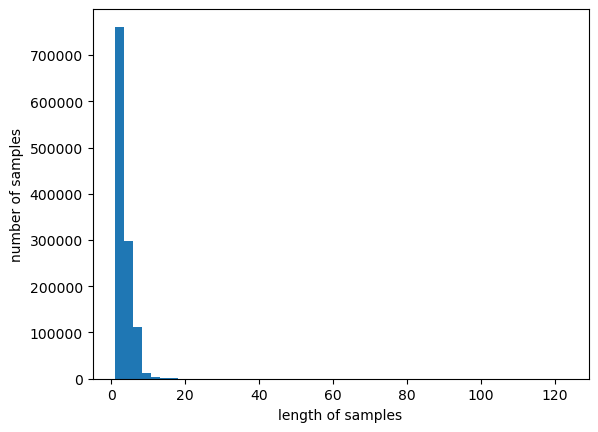

In [13]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 말뭉치 데이터에서 단어와 BIO태그만 불러와 학습용 데이터셋 생성
temp = []
for tag in ner_tags:
    temp += tag

In [15]:
# BIO태그별 각각의 값의 개수 카운트
tags = np.array(temp)

tag, cnt = np.unique(tags, return_counts=True)
pd.DataFrame({'ner tag': tag, 'cnt': cnt})

,ner tag,cnt
0,B_A,40131
1,B_C,108264
2,B_DT,155999
3,B_G,46214
4,B_P,18582
5,B_R,59293
6,B_T,14618
7,I,9484
8,O,3367902
9,X,14424


In [16]:
# 토크나이저 정의
tag_tokenizer = preprocessing.text.Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(ner_tags)

In [17]:
# 단어사전 및 태그 사전 크기
vocab_size = len(p.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1
print('BIO 태그 사전 크기:', tag_size)
print('단어 사전 크기:', vocab_size)

BIO 태그 사전 크기: 11
단어 사전 크기: 91077


In [18]:
# 학습용 단어 시퀀스 생성
x_train = [p.get_wordidx_sequence(sent) for sent in sentences]
y_train = tag_tokenizer.texts_to_sequences(ner_tags)
index_to_ner = tag_tokenizer.index_word # 시퀀스 인덱스를 NER로 변환 하기 위해 사용
index_to_ner[0] = 'PAD'
index_to_ner

{1: 'O',
 2: 'B_DT',
 3: 'B_C',
 4: 'B_R',
 5: 'B_G',
 6: 'B_A',
 7: 'B_P',
 8: 'B_T',
 9: 'X',
 10: 'I',
 0: 'PAD'}

In [19]:
# 시퀀스 패딩 처리
max_len = 30
x_train = preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = preprocessing.sequence.pad_sequences(y_train, padding='post', maxlen=max_len)

In [20]:
# 학습 데이터와 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=10)

In [21]:
# 출력 데이터 원핫인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=tag_size)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=tag_size)

print('학습 샘플 시퀀스 형상:', x_train.shape)
print('학습 샘플 레이블 형상:', y_train.shape)
print('테스트 샘플 시퀀스 형상:', x_test.shape)
print('테스트 샘플 레이블 형상:', y_test.shape)

학습 샘플 시퀀스 형상: (952828, 30)
학습 샘플 레이블 형상: (952828, 30, 11)
테스트 샘플 시퀀스 형상: (238207, 30)
테스트 샘플 레이블 형상: (238207, 30, 11)


In [22]:
# 모델 정의 (Bi-LSTM)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.40, recurrent_dropout=0.25)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.save('./model/ner_model.h5')

Epoch 1/10
7444/7444 [==============================] - 3532s 473ms/step - loss: 0.0031 - accuracy: 0.9945
Epoch 2/10
7444/7444 [==============================] - 4496s 604ms/step - loss: 4.3494e-04 - accuracy: 0.9991
Epoch 3/10
7444/7444 [==============================] - 4384s 589ms/step - loss: 3.4542e-04 - accuracy: 0.9992
Epoch 4/10
7444/7444 [==============================] - 3309s 444ms/step - loss: 3.0008e-04 - accuracy: 0.9993
Epoch 5/10
7444/7444 [==============================] - 3296s 443ms/step - loss: 2.7610e-04 - accuracy: 0.9994
Epoch 6/10
7444/7444 [==============================] - 3289s 442ms/step - loss: 2.5806e-04 - accuracy: 0.9994
Epoch 7/10
7444/7444 [==============================] - 3290s 442ms/step - loss: 2.4377e-04 - accuracy: 0.9994
Epoch 8/10
7444/7444 [==============================] - 3316s 445ms/step - loss: 2.3524e-04 - accuracy: 0.9994
Epoch 9/10
7444/7444 [==============================] - 3308s 444ms/step - loss: 2.2847e-04 - accuracy: 0.9995
Epoch

In [23]:
# 모델 평가
from tensorflow import keras
model = keras.models.load_model('./model/ner_model.h5')
print('평가 결과:', model.evaluate(x_test, y_test)[1])

7444/7444 [==============================] - 442s 59ms/step - loss: 0.0012 - accuracy: 0.9985
평가 결과: 0.9985098242759705


In [24]:
# 시퀀스를 NER 태그로 변환하는 함수
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace('PAD', 'O'))
        result.append(temp)
    return result

In [25]:
# f1 스코어
from seqeval.metrics import f1_score, classification_report
y_predicted = model.predict([x_test]) # 테스트 데이터셋의 NER 예측
pred_tags = sequences_to_tag(y_predicted) # 예측된 NER
test_tags = sequences_to_tag(y_test) # 실제 NER
print(classification_report(test_tags, pred_tags))
print('F1-score: {:.1%}'.format(f1_score(test_tags, pred_tags)))

7444/7444 [==============================] - 444s 60ms/step


c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_C seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_R seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_G seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.

              precision    recall  f1-score   support

           _       1.00      1.00      1.00      1991
          _A       0.99      0.96      0.98      7950
          _C       1.00      1.00      1.00     21697
         _DT       1.00      0.99      0.99     31229
          _G       1.00      1.00      1.00      9215
          _P       0.99      0.96      0.98      3621
          _R       1.00      0.99      0.99     11306
          _T       1.00      0.99      0.99      2925

   micro avg       1.00      0.99      0.99     89934
   macro avg       1.00      0.99      0.99     89934
weighted avg       1.00      0.99      0.99     89934

F1-score: 99.4%
